In [1]:
import pandas as pd
import pickle5 as pickle
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPooling1D, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding,  Concatenate, Lambda
from keras.models import Model
from sklearn.metrics import roc_auc_score,roc_curve, auc
from numpy import random
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
import seaborn as sns


import functions as f

In [2]:
def load_data(D,randomize=False):
    try:
        with open("df_train_"+str(D)+"D.pkl", "rb") as fh:
          df_train = pickle.load(fh)
    except:
        df_train = pd.read_pickle("hyppi-train-data.pkl")
    try:
        with open("df_test_"+str(D)+"D.pkl", "rb") as fh:
          df_test = pickle.load(fh)
    except:
        df_test = pd.read_pickle("hyppi-test-data.pkl")
    if randomize:
        return f.shuff_together(df_train,df_test)
    else:
        return df_train,df_test

df_train,df_test = load_data(3)
print('The data used will be:')
df_train[['Human','Pathogen']]

Median length of Human sequence is 450


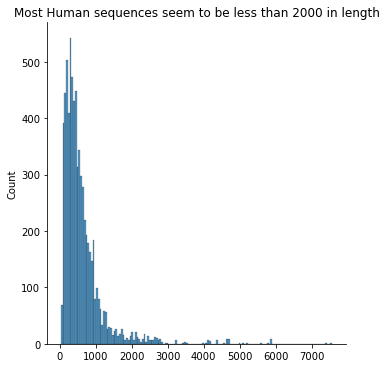

In [3]:
lengths = sorted(len(s) for s in df_train['Human'])
print("Median length of Human sequence is",lengths[len(lengths)//2])
_  = sns.displot(lengths)
_=plt.title("Most Human sequences seem to be less than 2000 in length")

Median length of Influenza sequence is 454


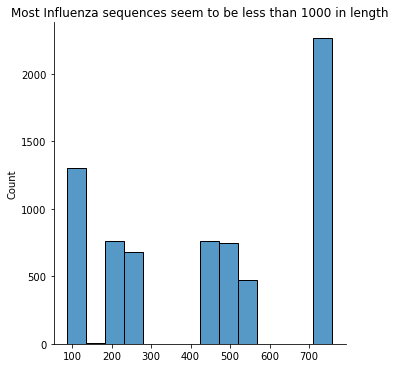

In [4]:
lengths = sorted(len(s) for s in df_train['Pathogen'])
print("Median length of Influenza sequence is",lengths[len(lengths)//2])
_  = sns.displot(lengths)
_=plt.title("Most Influenza sequences seem to be less than 1000 in length")

In [5]:
data1,data2,data1_test,data2_test,num_words,MAX_SEQUENCE_LENGTH,MAX_VOCAB_SIZE = f.get_seq_data_doubleip(7000,1000,df_train,df_test, pad='pre')

['Human', 'Pathogen', 'Joined', 'label']
max sequences1_train length: 7570
min sequences1_train length: 36
median sequences1_train length: 450
max word index sequences1_train: 22
max sequences2_train length: 759
min sequences2_train length: 87
median sequences2_train length: 454
max word index sequences2_train: 20
Found 22 unique tokens in tokenizer1.
Found 20 unique tokens in tokenizer2.
pre padding
Shape of data1 tensor: (7000, 1000)
Shape of data2 tensor: (7000, 1000)
max test_sequences1 length: 5890
min test_sequences1 length: 38
median test_sequences1 length: 443
max test_sequences2 length: 759
min test_sequences2 length: 87
median test_sequences2 length: 498
pre padding for test seq.
Shape of test_data1 tensor: (1899, 1000)
Shape of test_data2 tensor: (1899, 1000)
num_words is 22


In [6]:
EMBEDDING_DIM = 5
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 20
M_1D=10
DROP = 0.6

ip1 = f.att_model(MAX_SEQUENCE_LENGTH,EMBEDDING_DIM,num_words,DROP,True)
ip2 = f.att_model(MAX_SEQUENCE_LENGTH,EMBEDDING_DIM,num_words,DROP,True)

concatenator = Concatenate(axis=1)
x = concatenator([ip1.output, ip2.output])
x = Dense(128)(x)
#x = concatenator([x1.output, x2.output]) # output is N x 4M
#x = Dense(128, activation='relu')(x)
x = Dropout(DROP)(x)
output = Dense(1, activation="sigmoid",name="Final")(x)
model_doubleip = Model(inputs=[ip1.input,ip2.input], outputs=output)
#plot_model(model1D_CNN_doubleip, to_file='model_plot.png', show_shapes=True, show_layer_names=False)
model_doubleip.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
trains = [data1,data2,data2,data1]
tests = [data1_test,data2_test,data2_test,data1_test]

model_doubleip.fit(trains, df_train['label'].values,batch_size=BATCH_SIZE, epochs=EPOCHS,validation_data=(tests,df_test['label'].values))
print(roc_auc_score(df_test['label'].values, model_doubleip.predict(tests)))

[[ 0.5574417  -0.58122322  0.24578844  0.0571863  -0.82205726]
 [-0.5752304  -0.99694024  0.1794826   0.00502331  0.96102299]
 [-0.49433519 -0.2521099   0.41814972 -0.83998099  0.32391787]
 [-0.19629209 -0.39035042 -0.19093898  0.693012    0.93346749]
 [-0.91510029  0.82637965 -0.41474343 -0.82972579  0.61643041]
 [ 0.42181527 -0.49747895 -0.25294262 -0.93165284  0.07186688]
 [-0.64387441  0.59320646  0.04990079  0.03160207 -0.69821793]
 [-0.77166757 -0.28543248  0.55884198  0.82909016  0.54079044]
 [-0.50994572  0.69633364 -0.88456206 -0.90183629 -0.99230976]
 [ 0.98269006  0.36521755  0.77019457 -0.58245151 -0.06531715]
 [-0.72515091 -0.4058864   0.55545665 -0.59410617  0.52700894]
 [ 0.43763798 -0.70457671 -0.09032725 -0.37043663  0.1654985 ]
 [ 0.62803553 -0.59857125 -0.87397482 -0.30127997  0.79990068]
 [ 0.50293143  0.83990592  0.29525723 -0.49364689  0.59410597]
 [-0.39420726  0.5118133   0.22591178 -0.84671075  0.32715734]
 [ 0.47326492 -0.80402734 -0.68554294  0.70522015 -0.05

InvalidArgumentError:  indices[93,930] = 22 is not in [0, 22)
	 [[node model_2/embedding/embedding_lookup (defined at <ipython-input-6-9e55e05dc441>:24) ]] [Op:__inference_train_function_22558]

Errors may have originated from an input operation.
Input Source operations connected to node model_2/embedding/embedding_lookup:
 model_2/embedding/embedding_lookup/13622 (defined at /usr/lib/python3.8/contextlib.py:113)

Function call stack:
train_function
